In [1]:
import pandas as pd
import findspark
findspark.init('C:\spark\spark-3.0.0-preview2-bin-hadoop2.7')

In [95]:
import pandas as pd
import findspark
#findspark.init('C:\spark\spark-3.0.0-preview2-bin-hadoop2.7')
findspark.init()
import numpy as np 
from scipy.stats import mode
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier as gbc
from sklearn.ensemble import AdaBoostClassifier as ada
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier as MLP
from sklearn import svm
#from pyspark.ml.classification import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN


In [3]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

In [4]:
heart_df=pd.read_csv('framingham.csv')

In [5]:
spar_df=spark.createDataFrame(heart_df)

In [6]:
spar_df.columns

['male',
 'age',
 'education',
 'currentSmoker',
 'cigsPerDay',
 'BPMeds',
 'prevalentStroke',
 'prevalentHyp',
 'diabetes',
 'totChol',
 'sysBP',
 'diaBP',
 'BMI',
 'heartRate',
 'glucose',
 'TenYearCHD']

In [7]:
spar_df.describe().select("Summary","totChol","sysBP","diaBP","BMI","heartRate","glucose").show()

+-------+-------+------------------+------------------+-----+---------+-------+
|Summary|totChol|             sysBP|             diaBP|  BMI|heartRate|glucose|
+-------+-------+------------------+------------------+-----+---------+-------+
|  count|   4240|              4240|              4240| 4240|     4240|   4240|
|   mean|    NaN|132.35459905660377| 82.89775943396226|  NaN|      NaN|    NaN|
| stddev|    NaN|22.033299608849184|11.910394483305952|  NaN|      NaN|    NaN|
|    min|  107.0|              83.5|              48.0|15.54|     44.0|   40.0|
|    max|    NaN|             295.0|             142.5|  NaN|      NaN|    NaN|
+-------+-------+------------------+------------------+-----+---------+-------+



In [8]:
df = spar_df.filter(spar_df.age >50)
df.count()

1883

In [9]:
df = spar_df.filter('TenYearCHD==1 & male==1').show() #males who have label 1

+----+---+---------+-------------+----------+------+---------------+------------+--------+-------+-----+-----+-----+---------+-------+----------+
|male|age|education|currentSmoker|cigsPerDay|BPMeds|prevalentStroke|prevalentHyp|diabetes|totChol|sysBP|diaBP|  BMI|heartRate|glucose|TenYearCHD|
+----+---+---------+-------------+----------+------+---------------+------------+--------+-------+-----+-----+-----+---------+-------+----------+
|   0| 46|      2.0|            0|       0.0|   0.0|              0|           0|       0|  250.0|121.0| 81.0|28.73|     95.0|   76.0|         0|
|   0| 46|      3.0|            1|      23.0|   0.0|              0|           0|       0|  285.0|130.0| 84.0| 23.1|     85.0|   85.0|         0|
|   0| 43|      2.0|            0|       0.0|   0.0|              0|           1|       0|  228.0|180.0|110.0| 30.3|     77.0|   99.0|         0|
|   0| 45|      2.0|            1|      20.0|   0.0|              0|           0|       0|  313.0|100.0| 71.0|21.68|     79.

In [10]:
df = spar_df.filter('TenYearCHD==1 & currentSmoker==1').show()

+----+---+---------+-------------+----------+------+---------------+------------+--------+-------+-----+-----+-----+---------+-------+----------+
|male|age|education|currentSmoker|cigsPerDay|BPMeds|prevalentStroke|prevalentHyp|diabetes|totChol|sysBP|diaBP|  BMI|heartRate|glucose|TenYearCHD|
+----+---+---------+-------------+----------+------+---------------+------------+--------+-------+-----+-----+-----+---------+-------+----------+
|   1| 39|      4.0|            0|       0.0|   0.0|              0|           0|       0|  195.0|106.0| 70.0|26.97|     80.0|   77.0|         0|
|   0| 46|      2.0|            0|       0.0|   0.0|              0|           0|       0|  250.0|121.0| 81.0|28.73|     95.0|   76.0|         0|
|   0| 61|      3.0|            1|      30.0|   0.0|              0|           1|       0|  225.0|150.0| 95.0|28.58|     65.0|  103.0|         1|
|   0| 43|      2.0|            0|       0.0|   0.0|              0|           1|       0|  228.0|180.0|110.0| 30.3|     77.

In [11]:
spar_df.filter(spar_df.education.isNotNull()).show()

+----+---+---------+-------------+----------+------+---------------+------------+--------+-------+-----+-----+-----+---------+-------+----------+
|male|age|education|currentSmoker|cigsPerDay|BPMeds|prevalentStroke|prevalentHyp|diabetes|totChol|sysBP|diaBP|  BMI|heartRate|glucose|TenYearCHD|
+----+---+---------+-------------+----------+------+---------------+------------+--------+-------+-----+-----+-----+---------+-------+----------+
|   1| 39|      4.0|            0|       0.0|   0.0|              0|           0|       0|  195.0|106.0| 70.0|26.97|     80.0|   77.0|         0|
|   0| 46|      2.0|            0|       0.0|   0.0|              0|           0|       0|  250.0|121.0| 81.0|28.73|     95.0|   76.0|         0|
|   1| 48|      1.0|            1|      20.0|   0.0|              0|           0|       0|  245.0|127.5| 80.0|25.34|     75.0|   70.0|         0|
|   0| 61|      3.0|            1|      30.0|   0.0|              0|           1|       0|  225.0|150.0| 95.0|28.58|     65.

In [12]:
spar_df.filter(spar_df.glucose.isNotNull()).show()

+----+---+---------+-------------+----------+------+---------------+------------+--------+-------+-----+-----+-----+---------+-------+----------+
|male|age|education|currentSmoker|cigsPerDay|BPMeds|prevalentStroke|prevalentHyp|diabetes|totChol|sysBP|diaBP|  BMI|heartRate|glucose|TenYearCHD|
+----+---+---------+-------------+----------+------+---------------+------------+--------+-------+-----+-----+-----+---------+-------+----------+
|   1| 39|      4.0|            0|       0.0|   0.0|              0|           0|       0|  195.0|106.0| 70.0|26.97|     80.0|   77.0|         0|
|   0| 46|      2.0|            0|       0.0|   0.0|              0|           0|       0|  250.0|121.0| 81.0|28.73|     95.0|   76.0|         0|
|   1| 48|      1.0|            1|      20.0|   0.0|              0|           0|       0|  245.0|127.5| 80.0|25.34|     75.0|   70.0|         0|
|   0| 61|      3.0|            1|      30.0|   0.0|              0|           1|       0|  225.0|150.0| 95.0|28.58|     65.

In [13]:
re = spar_df.groupBy('TenYearCHD').count().collect()
category = [i[0] for i in re]
res_counts = [i[1] for i in re]

In [14]:
res_counts

[3596, 644]

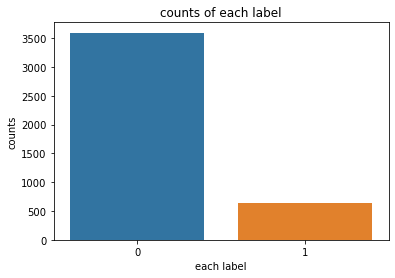

In [15]:
sns.barplot(category,res_counts)
plt.title('counts of each label')
plt.xlabel('each label')
plt.ylabel('counts')
plt.show()

In [16]:
heart_df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [17]:
heart_df.tail()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
4235,0,48,2.0,1,20.0,NaN,0,0,0,248.0,131.0,72.0,22.00,84.0,86.0,0
4236,0,44,1.0,1,15.0,0.0,0,0,0,210.0,126.5,87.0,19.16,86.0,NaN,0
4237,0,52,2.0,0,0.0,0.0,0,0,0,269.0,133.5,83.0,21.47,80.0,107.0,0
4238,1,40,3.0,0,0.0,0.0,0,1,0,185.0,141.0,98.0,25.60,67.0,72.0,0
4239,0,39,3.0,1,30.0,0.0,0,0,0,196.0,133.0,86.0,20.91,85.0,80.0,0


In [18]:
heart_df.TenYearCHD.value_counts() #count of labels

0    3596
1     644
Name: TenYearCHD, dtype: int64

In [19]:
pd.crosstab(heart_df.male,heart_df.TenYearCHD)

TenYearCHD,0,1
male,,
0,2119,301
1,1477,343


In [20]:
any(heart_df['male'].isna()) # checking for NA values

False

In [21]:
def find_missing(data):
    return sum(data.isna())

In [22]:
print("The number of missing values per column are:")
print(heart_df.apply(find_missing, axis=0))

The number of missing values per column are:
male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64


In [23]:
print("the number of missing values per row are:")
print(heart_df.apply(find_missing, axis=1))

the number of missing values per row are:
0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      0
13      0
14      1
15      0
16      0
17      0
18      0
19      0
20      0
21      1
22      0
23      0
24      0
25      0
26      1
27      0
28      0
29      0
       ..
4210    0
4211    0
4212    0
4213    0
4214    0
4215    0
4216    0
4217    0
4218    0
4219    0
4220    0
4221    0
4222    0
4223    0
4224    0
4225    0
4226    0
4227    0
4228    0
4229    1
4230    1
4231    0
4232    0
4233    0
4234    0
4235    1
4236    1
4237    0
4238    0
4239    0
Length: 4240, dtype: int64


In [24]:
list_of_nas=['education','cigsPerDay','BPMeds','totChol','BMI','heartRate','glucose']

In [25]:
for i in list_of_nas:
    m=mode(heart_df[i]).mode[0]
    heart_df[i]=heart_df[i].fillna(m)
    

In [26]:
any(heart_df['BMI'].isna())

False

In [27]:
spar_df=spark.createDataFrame(heart_df)

In [28]:
spar_df.show(truncate=False)

+----+---+---------+-------------+----------+------+---------------+------------+--------+-------+-----+-----+-----+---------+-------+----------+
|male|age|education|currentSmoker|cigsPerDay|BPMeds|prevalentStroke|prevalentHyp|diabetes|totChol|sysBP|diaBP|BMI  |heartRate|glucose|TenYearCHD|
+----+---+---------+-------------+----------+------+---------------+------------+--------+-------+-----+-----+-----+---------+-------+----------+
|1   |39 |4.0      |0            |0.0       |0.0   |0              |0           |0       |195.0  |106.0|70.0 |26.97|80.0     |77.0   |0         |
|0   |46 |2.0      |0            |0.0       |0.0   |0              |0           |0       |250.0  |121.0|81.0 |28.73|95.0     |76.0   |0         |
|1   |48 |1.0      |1            |20.0      |0.0   |0              |0           |0       |245.0  |127.5|80.0 |25.34|75.0     |70.0   |0         |
|0   |61 |3.0      |1            |30.0      |0.0   |0              |1           |0       |225.0  |150.0|95.0 |28.58|65.0    

In [29]:
spar_df.describe().select("Summary","totChol","sysBP","diaBP","BMI","heartRate","glucose").show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+
|Summary|           totChol|             sysBP|             diaBP|               BMI|         heartRate|           glucose|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|              4240|              4240|              4240|              4240|              4240|              4240|
|   mean|236.73844339622642|132.35459905660377| 82.89775943396226|25.784620283018874| 75.87877358490566| 81.32641509433962|
| stddev|44.328953627206694|22.033299608849184|11.910394483305952| 4.077826102272104|12.023937060119845|22.919884887634762|
|    min|             107.0|              83.5|              48.0|             15.54|              44.0|              40.0|
|    max|             696.0|             295.0|             142.5|              56.8|             143.0|             394.0|
+-------

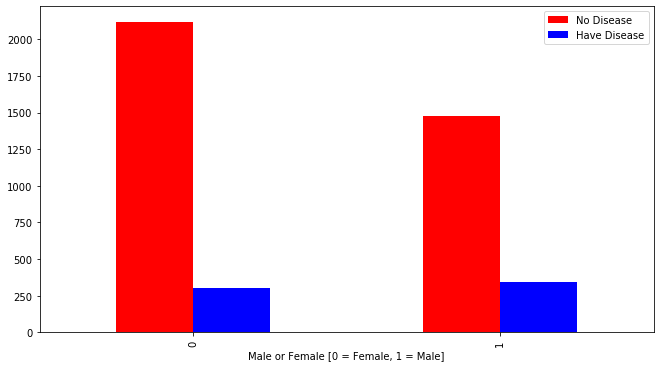

In [36]:
pd.crosstab(heart_df.male,heart_df.TenYearCHD).plot(kind="bar",figsize=(11,6),color=['red','blue' ])
plt.xlabel('Male or Female [0 = Female, 1 = Male]')
plt.legend(["No Disease", "Have Disease"])
plt.show()

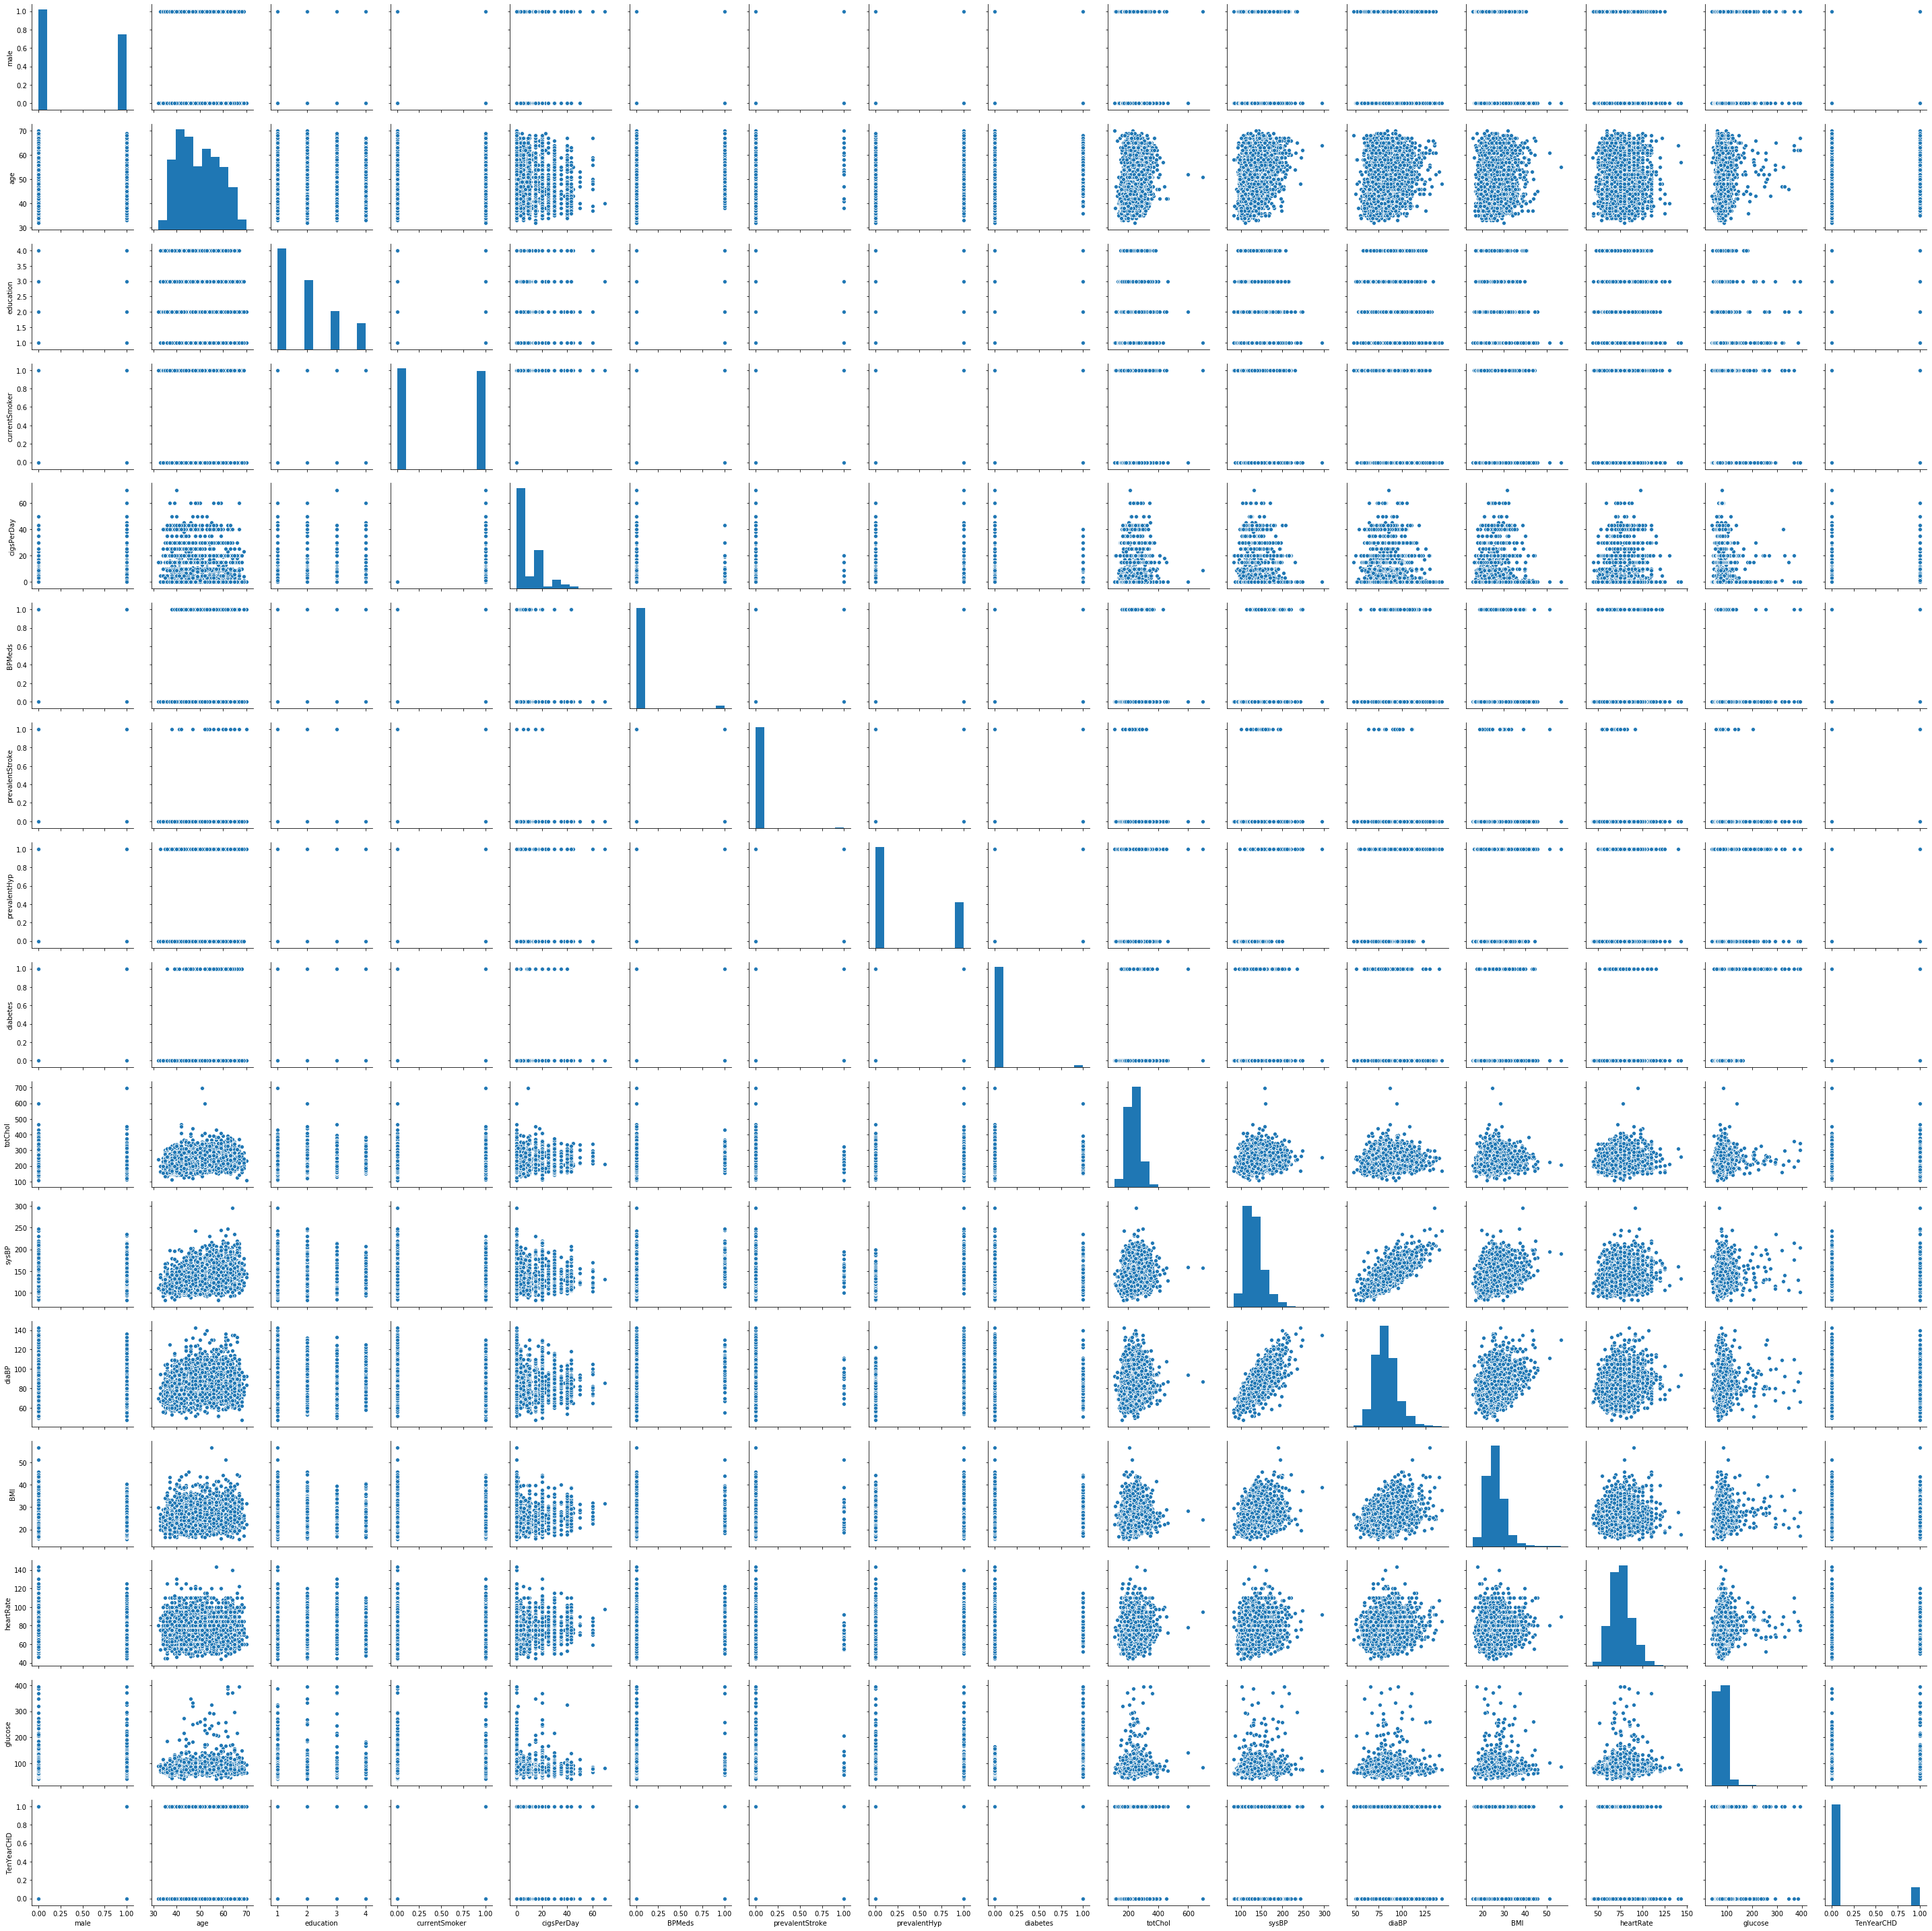

In [37]:
sns.pairplot(heart_df)

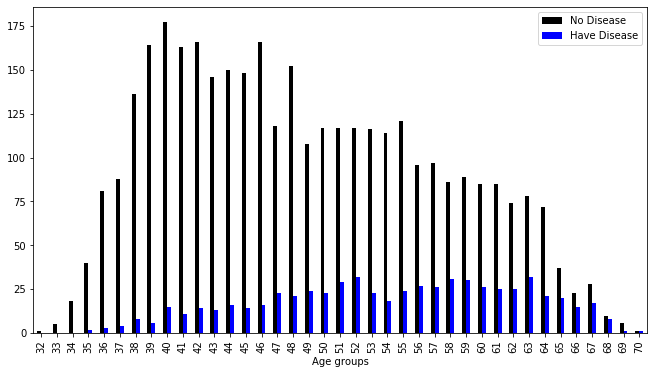

In [38]:
pd.crosstab(heart_df.age,heart_df.TenYearCHD).plot(kind="bar",figsize=(11,6),color=['black','blue' ])
plt.xlabel('Age groups')
plt.legend(["No Disease", "Have Disease"])
plt.show()

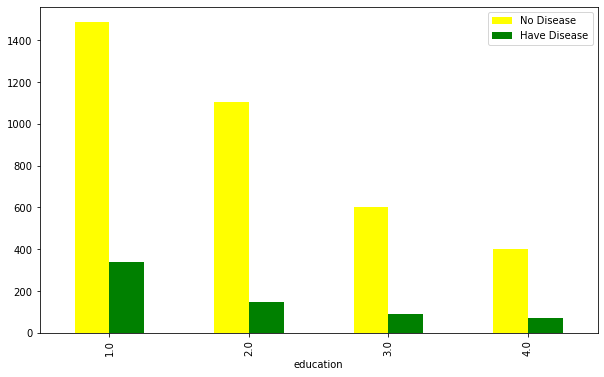

In [39]:
pd.crosstab(heart_df.education,heart_df.TenYearCHD).plot(kind="bar",figsize=(10,6),color=['yellow','green' ])
plt.xlabel('education')
plt.legend(["No Disease", "Have Disease"])
plt.show()

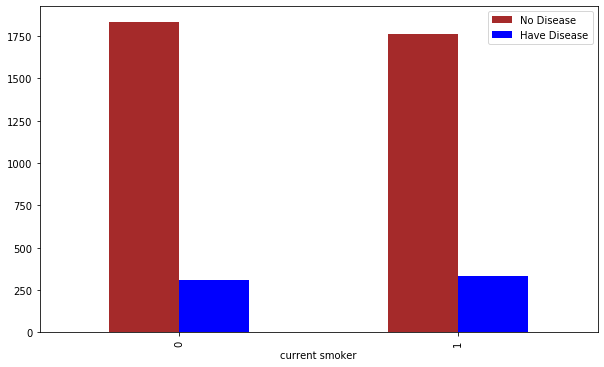

In [40]:
pd.crosstab(heart_df.currentSmoker,heart_df.TenYearCHD).plot(kind="bar",figsize=(10,6),color=['brown','blue' ])
plt.xlabel('current smoker')
plt.legend(["No Disease", "Have Disease"])
plt.show()

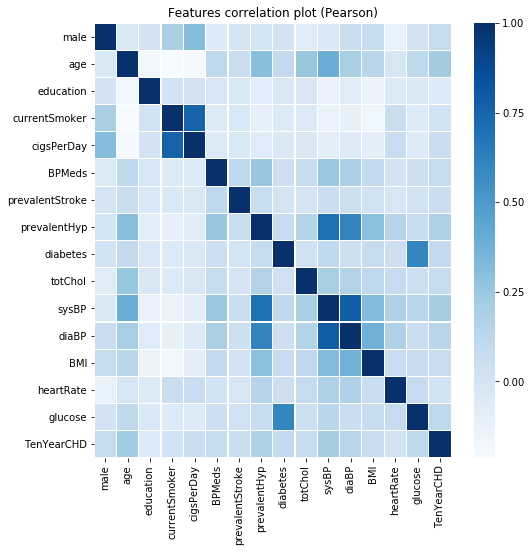

In [41]:
plt.figure(figsize = (8,8))
plt.title('Features correlation plot (Pearson)')
corr = heart_df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Blues")
plt.show()

In [42]:
heart_df['education']

0       4.0
1       2.0
2       1.0
3       3.0
4       3.0
5       2.0
6       1.0
7       2.0
8       1.0
9       1.0
10      1.0
11      2.0
12      1.0
13      3.0
14      2.0
15      2.0
16      3.0
17      2.0
18      2.0
19      2.0
20      2.0
21      1.0
22      1.0
23      3.0
24      2.0
25      4.0
26      1.0
27      2.0
28      3.0
29      1.0
       ... 
4210    1.0
4211    2.0
4212    2.0
4213    2.0
4214    3.0
4215    1.0
4216    3.0
4217    1.0
4218    1.0
4219    1.0
4220    1.0
4221    1.0
4222    3.0
4223    4.0
4224    2.0
4225    4.0
4226    1.0
4227    4.0
4228    1.0
4229    3.0
4230    1.0
4231    3.0
4232    1.0
4233    1.0
4234    3.0
4235    2.0
4236    1.0
4237    2.0
4238    3.0
4239    3.0
Name: education, Length: 4240, dtype: float64

In [43]:
#heart_df=heart_df.drop(['BPMeds','cigsPerDay','male','education','prevalentHyp', 'prevalentStroke','diabetes','currentSmoker'], axis=1)

In [44]:
x = heart_df.iloc[:, :-1]

In [45]:
y = heart_df.iloc[:, -1]

In [46]:
r = RandomForestClassifier(random_state=101)
rfe = RFECV(estimator=r, step=1, cv=StratifiedKFold(10), scoring='accuracy')
rfe.fit(x, y)

C:\Users\frank\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\frank\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\frank\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\frank\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.2

C:\Users\frank\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\frank\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\frank\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\frank\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.2

C:\Users\frank\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\frank\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\frank\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\frank\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.2

C:\Users\frank\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\frank\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\frank\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\frank\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.2

C:\Users\frank\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\frank\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\frank\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\frank\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.2

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                       criterion='gini', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators='warn', n_jobs=None,
                                       oob_score=False, random_state=101,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

In [47]:
print('Optimal number of features: {}'.format(rfe.n_features_))

Optimal number of features: 14


In [48]:

print(np.where(rfe.support_ == False)[0])

x.drop(x.columns[np.where(rfe.support_ == False)[0]], axis=1, inplace=True)

[6]


In [49]:
rfe.estimator_.feature_importances_

array([0.02243702, 0.12086396, 0.03544832, 0.01293692, 0.05286957,
       0.00578531, 0.01855973, 0.00664591, 0.12214266, 0.13229519,
       0.11705912, 0.13427729, 0.09992147, 0.11875754])

In [50]:
dat = pd.DataFrame()
dat['features'] = x.columns
dat['feature_importance'] = rfe.estimator_.feature_importances_

dat = dat.sort_values(by='feature_importance', ascending=False)
dat

,features,feature_importance
11,BMI,0.134277
9,sysBP,0.132295
8,totChol,0.122143
1,age,0.120864
13,glucose,0.118758
10,diaBP,0.117059
12,heartRate,0.099921
4,cigsPerDay,0.052870
2,education,0.035448
0,male,0.022437


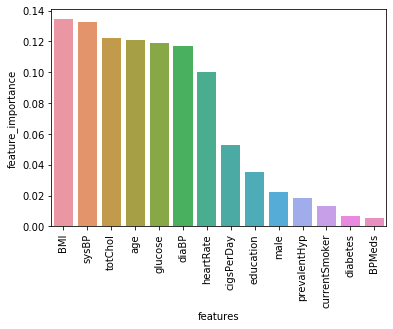

In [51]:
s = sns.barplot(x='features',y='feature_importance',data=dat)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

In [52]:
#heart_df=heart_df.drop(['BPMeds','cigsPerDay','male','education','prevalentHyp', 'prevalentStroke','diabetes','currentSmoker','heartRate'], axis=1)

In [53]:
x = heart_df.iloc[:, :-1]

In [54]:
y = heart_df.iloc[:, -1]

In [55]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [56]:
x_train

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
1940,0,52,4.0,1,20.0,0.0,0,0,0,240.0,110.0,70.0,22.52,75.0,75.0
1670,1,37,2.0,1,20.0,0.0,0,0,0,272.0,114.5,80.0,27.60,63.0,57.0
264,1,57,1.0,0,0.0,0.0,0,1,0,176.0,134.0,97.0,38.14,68.0,94.0
385,1,39,2.0,0,0.0,0.0,0,0,0,235.0,120.0,80.0,27.23,62.0,87.0
2570,1,47,3.0,0,0.0,0.0,0,0,1,199.0,161.0,102.0,29.17,58.0,75.0
3523,1,43,3.0,1,10.0,0.0,0,0,0,285.0,100.5,66.0,22.05,65.0,75.0
2347,0,40,3.0,0,0.0,0.0,0,0,0,226.0,118.0,72.0,24.75,87.0,79.0
3632,0,57,1.0,0,0.0,0.0,0,1,0,285.0,197.0,72.0,23.41,68.0,78.0
701,1,40,1.0,0,0.0,0.0,0,0,0,206.0,110.0,67.5,25.88,62.0,80.0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0


In [57]:
smo=SMOTE(random_state=10,ratio='auto',kind='regular')

In [58]:
x_train_n,y_train_n=smo.fit_sample(x_train,y_train)

In [59]:
x_test_n,y_test_n=smo.fit_sample(x_test,y_test)

In [60]:
x_train_n.shape

(5040, 15)

In [61]:
s=StandardScaler()
x_train_n = s.fit_transform(x_train_n)
x_test_n= s.transform(x_test_n)

In [62]:
R= RandomForestClassifier(random_state=0,
                             criterion='gini',
                             n_estimators=2000,
                             verbose=False)

In [63]:
R.fit(x_train_n, y_train_n)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=0,
                       verbose=False, warm_start=False)

In [64]:
pr = R.predict(x_test_n)

In [65]:
con_mat=metrics.confusion_matrix(y_test_n, pr)
con_mat

array([[1040,   36],
       [ 356,  720]], dtype=int64)

In [66]:
f1=metrics.f1_score(pr,y_test_n)
print(f1)

0.7860262008733624


In [67]:
r=metrics.roc_auc_score(y_test_n,pr)
print(r)

0.8178438661710037


In [68]:
metrics.accuracy_score(pr,y_test_n)

0.8178438661710037

In [69]:
print(classification_report(y_test_n, pr))

              precision    recall  f1-score   support

           0       0.74      0.97      0.84      1076
           1       0.95      0.67      0.79      1076

    accuracy                           0.82      2152
   macro avg       0.85      0.82      0.81      2152
weighted avg       0.85      0.82      0.81      2152



In [70]:
predict=['male','age','education','currentSmoker','cigsPerDay','BPMeds','prevalentSmoker','prevalentHyp','diabetes','totChol','sysBP','diaBP','BMI','heartRate','glucose']

In [71]:
d_f = pd.DataFrame({'Features in the dataset': predict, 'Importance of features': R.feature_importances_})

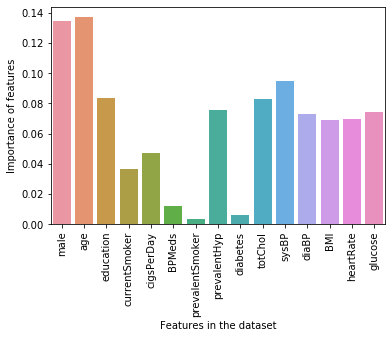

In [72]:
s = sns.barplot(x='Features in the dataset',y='Importance of features',data=d_f)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

In [73]:
Log= LogisticRegression(penalty='l2')

In [74]:
Log.fit(x_train_n,y_train_n)
p=Log.predict(x_test_n)
score = Log.score(x_test_n, y_test_n)
pb=Log.predict_proba(x_test_n)
pb=pb[:,1]
f1=metrics.f1_score(p,y_test_n)
r=metrics.roc_auc_score(y_test_n,p)
print("accuracy score is:",score)
print("f1 score is:",f1)

accuracy score is: 0.6696096654275093
f1 score is: 0.6615897191813422


C:\Users\frank\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [75]:
print(classification_report(y_test_n, p))

              precision    recall  f1-score   support

           0       0.66      0.69      0.68      1076
           1       0.68      0.65      0.66      1076

    accuracy                           0.67      2152
   macro avg       0.67      0.67      0.67      2152
weighted avg       0.67      0.67      0.67      2152



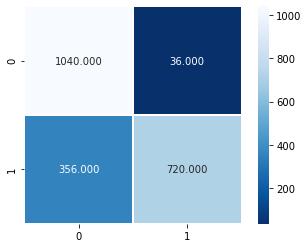

In [76]:
sns.heatmap(con_mat, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')

In [77]:
Naive_bayes=GaussianNB()

In [78]:
Naive_bayes.fit(x_train_n,y_train_n)
p=Naive_bayes.predict(x_test_n)
score = Naive_bayes.score(x_test_n, y_test_n)
#pb=Log.predict_proba(x_test_n)
#pb=pb[:,1]
f1=metrics.f1_score(p,y_test_n)
r=metrics.roc_auc_score(y_test_n,p)
print("accuracy score is:",score)
print("f1 score is:",f1)

accuracy score is: 0.6189591078066915
f1 score is: 0.4868585732165207


In [79]:
print(classification_report(y_test_n, p))

              precision    recall  f1-score   support

           0       0.58      0.88      0.70      1076
           1       0.75      0.36      0.49      1076

    accuracy                           0.62      2152
   macro avg       0.66      0.62      0.59      2152
weighted avg       0.66      0.62      0.59      2152



In [80]:
dt=tree.DecisionTreeClassifier(criterion='gini', splitter='best',max_depth=10)

In [81]:
dt.fit(x_train_n,y_train_n)
p=dt.predict(x_test_n)
score = dt.score(x_test_n, y_test_n)
#pb=Log.predict_proba(x_test_n)
#pb=pb[:,1]
f1=metrics.f1_score(p,y_test_n)
r=metrics.roc_auc_score(y_test_n,p)
print("accuracy score is:",score)
print("f1 score is:",f1)

accuracy score is: 0.7365241635687733
f1 score is: 0.7039164490861618


In [82]:
print(classification_report(y_test_n, p))

              precision    recall  f1-score   support

           0       0.69      0.85      0.76      1076
           1       0.80      0.63      0.70      1076

    accuracy                           0.74      2152
   macro avg       0.75      0.74      0.73      2152
weighted avg       0.75      0.74      0.73      2152



In [83]:
knn = KNeighborsClassifier(n_neighbors=25)

In [84]:
knn.fit(x_train_n,y_train_n)
p=knn.predict(x_test_n)
score = knn.score(x_test_n, y_test_n)
#pb=Log.predict_proba(x_test_n)
#pb=pb[:,1]
f1=metrics.f1_score(p,y_test_n)
r=metrics.roc_auc_score(y_test_n,p)
print("accuracy score is:",score)
print("f1 score is:",f1)

accuracy score is: 0.654275092936803
f1 score is: 0.6497175141242938


In [85]:
print(classification_report(y_test_n, p))

              precision    recall  f1-score   support

           0       0.65      0.67      0.66      1076
           1       0.66      0.64      0.65      1076

    accuracy                           0.65      2152
   macro avg       0.65      0.65      0.65      2152
weighted avg       0.65      0.65      0.65      2152



In [86]:
sv = svm.SVC()

In [87]:
sv.fit(x_train_n,y_train_n)
p=sv.predict(x_test_n)
score = sv.score(x_test_n, y_test_n)
#pb=Log.predict_proba(x_test_n)
#pb=pb[:,1]
f1=metrics.f1_score(p,y_test_n)
r=metrics.roc_auc_score(y_test_n,p)
print("accuracy score is:",score)
print("f1 score is:",f1)

accuracy score is: 0.7044609665427509
f1 score is: 0.6652631578947369


In [88]:
print(classification_report(y_test_n, p))

              precision    recall  f1-score   support

           0       0.67      0.82      0.74      1076
           1       0.77      0.59      0.67      1076

    accuracy                           0.70      2152
   macro avg       0.72      0.70      0.70      2152
weighted avg       0.72      0.70      0.70      2152



In [102]:
gb=gbc(loss='deviance', learning_rate=0.1, n_estimators=1000)

In [103]:
gb.fit(x_train_n,y_train_n)
p=gb.predict(x_test_n)
score = gb.score(x_test_n, y_test_n)
#pb=Log.predict_proba(x_test_n)
#pb=pb[:,1]
f1=metrics.f1_score(p,y_test_n)
r=metrics.roc_auc_score(y_test_n,p)
print("accuracy score is:",score)
print("f1 score is:",f1)

accuracy score is: 0.8671003717472119
f1 score is: 0.8558467741935483


In [104]:
print(classification_report(y_test_n, p))

              precision    recall  f1-score   support

           0       0.82      0.95      0.88      1076
           1       0.94      0.79      0.86      1076

    accuracy                           0.87      2152
   macro avg       0.88      0.87      0.87      2152
weighted avg       0.88      0.87      0.87      2152



In [92]:
mlp=MLP(hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=0.001,max_iter=200)

In [93]:
mlp.fit(x_train_n,y_train_n)
p=mlp.predict(x_test_n)
score = mlp.score(x_test_n, y_test_n)
#pb=Log.predict_proba(x_test_n)
#pb=pb[:,1]
f1=metrics.f1_score(p,y_test_n)
r=metrics.roc_auc_score(y_test_n,p)
print("accuracy score is:",score)
print("f1 score is:",f1)

accuracy score is: 0.720724907063197
f1 score is: 0.6821787414066632


C:\Users\frank\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [94]:
print(classification_report(y_test_n, p))

              precision    recall  f1-score   support

           0       0.68      0.84      0.75      1076
           1       0.79      0.60      0.68      1076

    accuracy                           0.72      2152
   macro avg       0.73      0.72      0.72      2152
weighted avg       0.73      0.72      0.72      2152



In [105]:
ad=ada(learning_rate=0.1, n_estimators=1000)

In [106]:
ad.fit(x_train_n,y_train_n)
p=ad.predict(x_test_n)
score = ad.score(x_test_n, y_test_n)
#pb=Log.predict_proba(x_test_n)
#pb=pb[:,1]
f1=metrics.f1_score(p,y_test_n)
r=metrics.roc_auc_score(y_test_n,p)
print("accuracy score is:",score)
print("f1 score is:",f1)

accuracy score is: 0.8517657992565055
f1 score is: 0.8392947103274558


In [107]:
print(classification_report(y_test_n, p))

              precision    recall  f1-score   support

           0       0.80      0.93      0.86      1076
           1       0.92      0.77      0.84      1076

    accuracy                           0.85      2152
   macro avg       0.86      0.85      0.85      2152
weighted avg       0.86      0.85      0.85      2152



In [117]:
acc={'Random Forest':0.78602,'Logistic Regression':0.66158,'Naive Bayes':0.48685,'Decision Tree':0.703916,'KNN':0.649717,'SVM':0.665263,'Gradient Boosting Classifier':0.85584,'MLP Classifier':0.682178,'Adaboost Classifier':0.83929}

{'Naive Bayes': 0.48685, 'KNN': 0.649717, 'Logistic Regression': 0.66158, 'SVM': 0.665263, 'MLP Classifier': 0.682178, 'Decision Tree': 0.703916, 'Random Forest': 0.78602, 'Adaboost Classifier': 0.83929, 'Gradient Boosting Classifier': 0.85584}


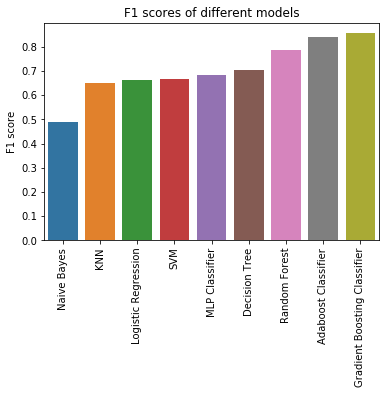

In [120]:
acc={keys: val for keys, val in sorted(acc.items(), key=lambda item: item[1])}
print(acc)
s=sns.barplot(x=list(acc.keys()), y=list(acc.values()))
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.title('F1 scores of different models')
plt.ylabel('F1 score')
plt.show()